<a href="https://colab.research.google.com/github/imammarzuki/Eksperimen/blob/main/NCF_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout

# Dataset fiktif contoh destinasi wisata
data = {
    'User': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'Destinasi': ['Bali', 'Yogyakarta', 'Lombok', 'Jakarta', 'Medan', 'Bandung', 'Makassar', 'Bali', 'Medan', 'Yogyakarta'],
    'Rating': [5, 4, 3, 2, 1, 4, 3, 5, 2, 4]
}

# Membuat DataFrame
df = pd.DataFrame(data)


In [2]:
# Encoding destinasi wisata dan pengguna menjadi integer
dest_map = {dest: idx for idx, dest in enumerate(df['Destinasi'].unique())}
user_map = {user: idx for idx, user in enumerate(df['User'].unique())}
df['Destinasi'] = df['Destinasi'].map(dest_map)
df['User'] = df['User'].map(user_map)

In [3]:
# Membagi data menjadi set pelatihan dan pengujian
X = df[['User', 'Destinasi']].values
y = df['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Normalisasi nilai rating
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

In [5]:
# Membuat model Neural Collaborative Filtering (NCF)
n_users = df['User'].nunique()
n_dests = df['Destinasi'].nunique()
embedding_dim = 8

In [6]:
# Input
user_input = Input(shape=(1,))
dest_input = Input(shape=(1,))

In [7]:
# Embedding untuk pengguna dan destinasi
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_dim, input_length=1)(user_input)
dest_embedding = Embedding(input_dim=n_dests, output_dim=embedding_dim, input_length=1)(dest_input)

In [8]:
# Flatten layer
user_vec = Flatten()(user_embedding)
dest_vec = Flatten()(dest_embedding)

In [9]:
# Concatenate dan dense layers
concat = Concatenate()([user_vec, dest_vec])
fc1 = Dense(64, activation='relu')(concat)
fc2 = Dense(32, activation='relu')(fc1)
dropout = Dropout(0.3)(fc2)
output = Dense(1)(dropout)

In [10]:
# Model
model = Model([user_input, dest_input], output)
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Melatih model
model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=100, batch_size=8, verbose=1)


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.0103
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 1.0017
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 0.9917
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 0.9915
Epoch 5/100
1/1 [==============================] - 0s 10ms/step - loss: 0.9810
Epoch 6/100
1/1 [==============================] - 0s 9ms/step - loss: 0.9900
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 0.9766
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 0.9691
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 0.9662
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 0.9669
Epoch 11/100
1/1 [==============================] - 0s 10ms/step - loss: 0.9693
Epoch 12/100
1/1 [==============================] - 0s 9ms/step - loss: 0.9488
Epoch 13/100
1/1 [==============================] - 0s

In [12]:
# Prediksi
y_pred = model.predict([X_test[:, 0], X_test[:, 1]])

1/1 [==============================] - 0s 327ms/step


In [13]:
# Evaluasi hasil
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler.inverse_transform(y_pred).flatten()

mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

In [14]:
# Mengonversi nilai rating ke kelas (biner untuk confusion matrix)
threshold = 3.0
y_test_binary = np.where(y_test_orig >= threshold, 1, 0)
y_pred_binary = np.where(y_pred_orig >= threshold, 1, 0)

conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")



Confusion Matrix:
[[1 0]
 [0 1]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Mean Absolute Error (MAE): 0.4243568181991577
Root Mean Squared Error (RMSE): 0.45395844635055826


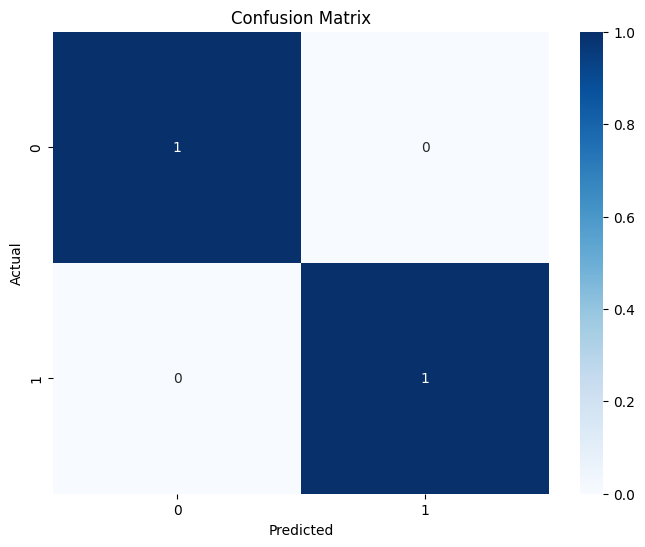

In [15]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()